# Monte Carlo Methods
in this notebook, you will write your own implementations of many Monte carlo (MC) algorithms.

## Create some useful functions

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

## Part 0: Explore BlackJackEnv

We begin by importing the necessary packages.

In [ ]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [ ]:
# Creating the BlackJack environment
env = gym.make('Blackjack-v0')

In [ ]:
# Check the observation and action space
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [ ]:
for i_episode in range(3):
  state = env.reset()
  while True:
    print(state)
    action = env.action_space.sample()
    print('stick') if action==0 else print('hit')
    state, reward, done, info = env.step(action)
    if done:
      print('Game over! Reward: ', reward)
      print('You won :)\n') if reward > 0 else print('You lost :( \n')
      break

(13, 3, False)
stick
Game over! Reward:  1.0
You won :)

(19, 10, False)
hit
Game over! Reward:  -1.0
You lost :( 

(21, 9, True)
stick
Game over! Reward:  1.0
You won :)



In [ ]:
# Create a function which is for playing one episode with a policy
def play_one_random_episode(bj_env):
  episode=[]
  state = bj_env.reset()
  
  while True:
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
    action = np.random.choice(np.arange(2), p=probs)
    new_state, reward, done, _ = bj_env.step(action)
    episode.append((state, action, reward))
    state = new_state
    if done:
      break
  
  return episode

In [ ]:
# Play 5 episodes
for _ in range(5):
  episode = play_one_random_episode(env)
  print(episode)

[((18, 2, False), 1, -1.0)]
[((16, 1, False), 1, 0.0), ((18, 1, False), 1, -1.0)]
[((7, 7, False), 1, 0.0), ((17, 7, False), 1, 0.0), ((18, 7, False), 1, 0.0), ((20, 7, False), 0, 1.0)]
[((19, 10, False), 0, -1.0)]
[((16, 6, False), 1, -1.0)]


## Playing random games

In [ ]:
def mc_pred_q(env, num_episodes, generate_episode, gamma=1.0):
  # initialize empty dicts of arrays
  returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
  N = defaultdict(lambda: np.zeros(env.action_space.n))
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  # Loop over the episodes
  for i_episode in range(1, num_episodes+1):
    # Monitor the progress
    if i_episode % 1000 == 0:
      print("Episode {}/{}.".format(i_episode, num_episodes))
    # Play an episode
    episode = play_one_random_episode(env)
    # Save the results in the variables
    states, actions, rewards = zip(*episode)
    # Prepare the discounting
    discounts = np.array([gamma**i for i in range(len(states)+1)])

    # Update the values for the Q-table
    for i, state in enumerate(states):
      returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
      N[state][actions[i]] += 1.0
      Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
  
  return Q

In [ ]:
Q = mc_pred_q(env, 500000, play_one_random_episode)

In [ ]:
# Define the state value function
v_to_plot = {}
for k, v in Q.items():
  if k[0] > 18:
    v_to_plot[k] = np.dot([0.8, 0.2], v)
  else:
    v_to_plot[k] = np.dot([0.2, 0.8], v)

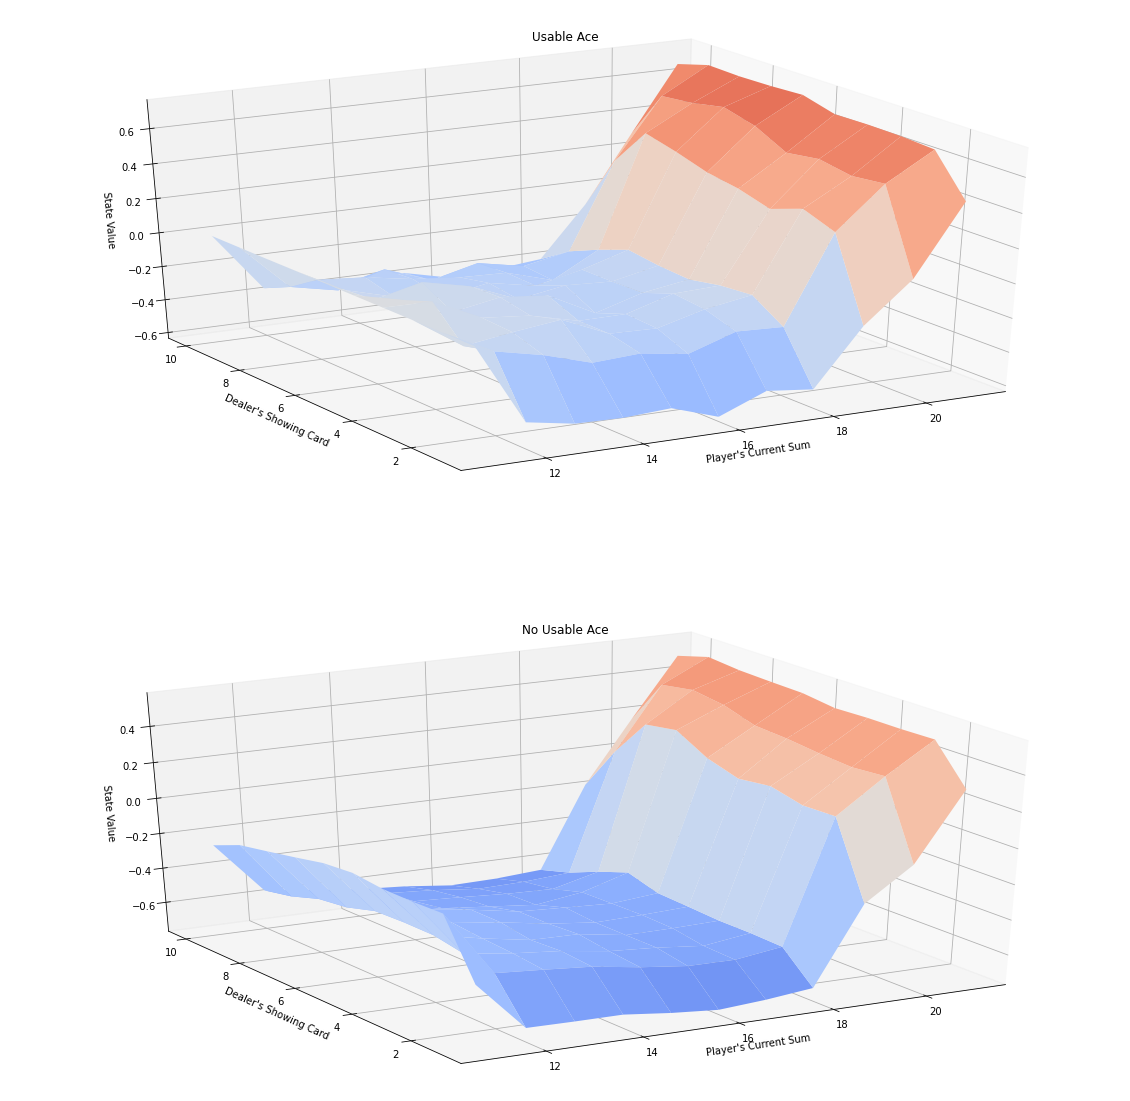

In [ ]:
plot_blackjack_values(v_to_plot)

## Playing based on epsilon greedy

In [ ]:
def generate_episode_from_Q_table(env, Q, eps):
  episode = []
  state = env.reset()
  nA = env.action_space.n
  while True:
    if state in Q:
      action = np.random.choice(np.arange(nA), p=get_probs(state, eps, nA))
    else:
      action = env.action_space.sample()
    new_state, last_reward, is_done, _ = env.step(action)
    episode.append((state, action, last_reward))
    state = new_state
    if is_done:
      break
  return episode

  

def get_probs(state, eps, nA):
  prob_list = np.zeros(nA)

  if_random = np.ones(nA) / nA * eps

  if_greedy = np.zeros(nA)
  if_greedy[np.argmax(Q[state])] = 1 * (1 - eps)

  prob_list = if_random + if_greedy
  return prob_list


def update_Q(env, episode, Q, alpha, gamma):
  state, action, rewards = zip(*episode)
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])
  for i, state in enumerate(state):
    old_Q = Q[state][action[i]]
    new_Q = old_Q + alpha*(sum(np.multiply(rewards[i:], discounts[:-(i+1)])) - old_Q)
    Q[state][action[i]] = new_Q
  return Q



In [ ]:
def epsilon_greedy(env, num_episodes, gamma=1.0, alpha=0.02, eps_start=1.0, eps_decay=0.99999, eps_min=0.01):
  nA = env.action_space.n
  Q = defaultdict(lambda: np.zeros(nA))

  for which_episode in range(num_episodes + 1):
    if which_episode % 500 == 0:
      print(f"{which_episode}/{num_episodes}")

    epsilon = max(eps_start * (eps_decay ** which_episode), eps_min)
    episode = generate_episode_from_Q_table(env, Q, epsilon)
    Q = update_Q(env, episode, Q, alpha, gamma)
  
  policy = dict((k,np.argmax(v)) for k, v in Q.items())
  return Q, policy

In [ ]:
1.0 * 0.99999 ** 1000000

4.539765980967911e-05

In [ ]:
Q, policy = epsilon_greedy(env, 1000000, alpha = 0.023)

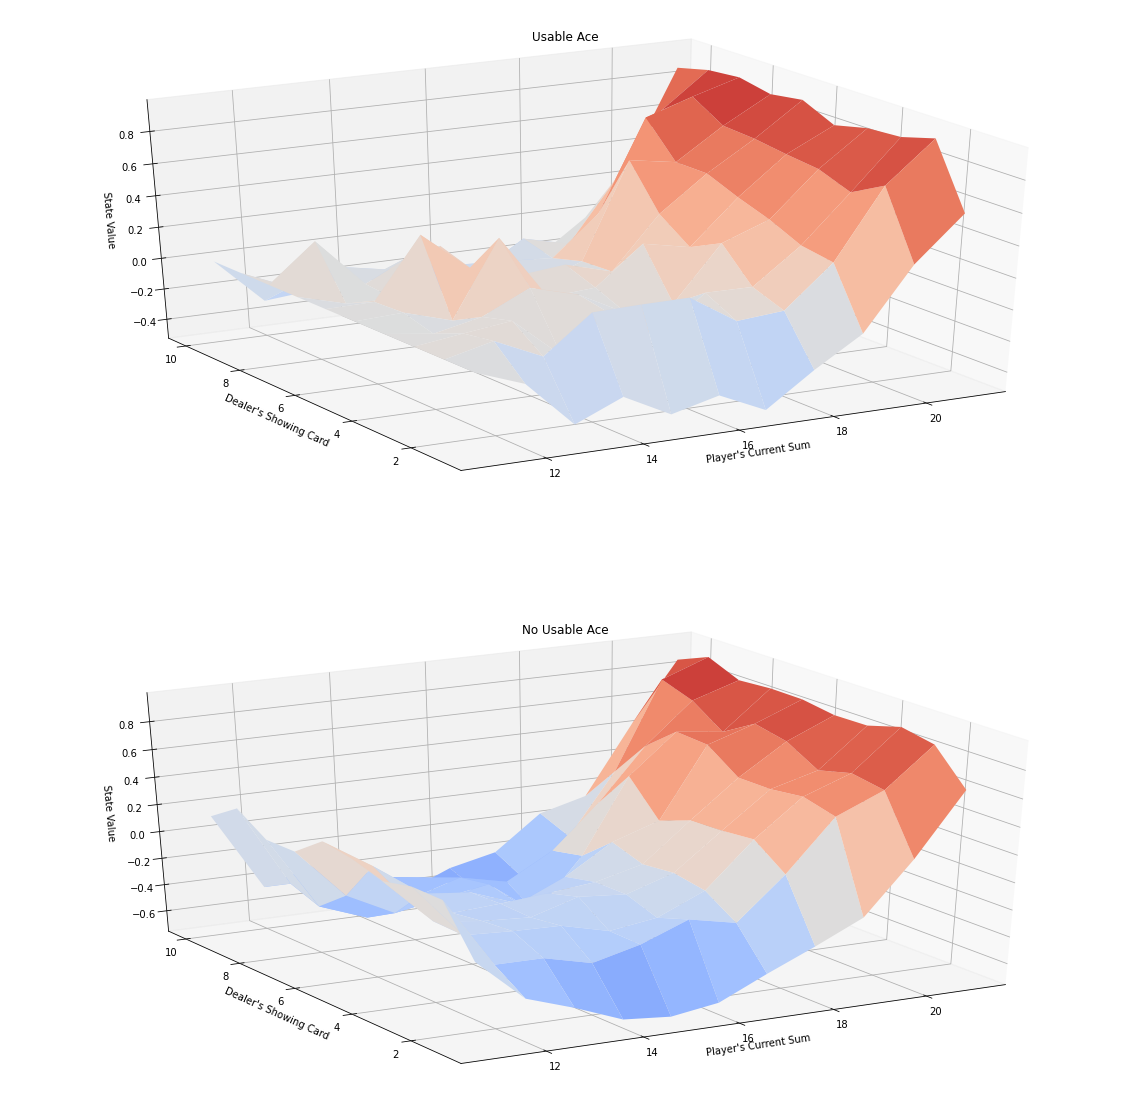

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

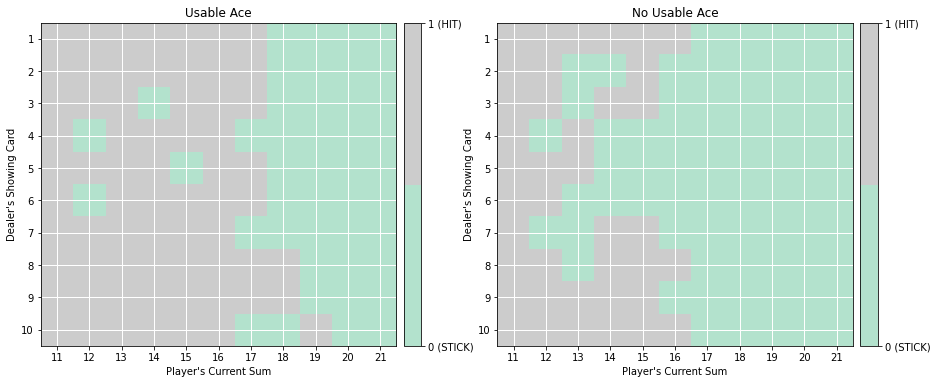

In [ ]:
plot_policy(policy)